In [1]:
# radimo klasterovanje na skupu dogs na osnovu visine i tezine

import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('../dogs.csv')
df.describe()

,height,weight
count,11.000000,11.000000
mean,19.545455,59.818182
std,7.659812,47.023012
min,6.000000,7.000000
25%,17.000000,27.500000
50%,20.000000,50.000000
75%,24.000000,74.000000
max,32.000000,160.000000


In [3]:
df.head()

,breed,height,weight
0,Border Collie,20,45
1,Boston Terrier,16,20
2,Brittany Spaniel,18,35
3,Bullmastiff,27,120
4,Chihuahua,8,8


In [4]:
# primetimo da K-means ne moze direktno da radi sa kategorickima tributima, zato sto nema smisla racuanti
# za njih centroide (npr kako bi bio prosek za Border Collie i Bullmastif, pa nikako)
# kategoricke moramo nekako da pretvorimo u numericke (to nismo radili u ovom primeru vec smo ih samo ignorisali)
# npr jedan nacin za ovo je objasnjen na slajovima. Za svaku kateogriju koja postoji u okviru nekog 
# atributa (za svaki kategoricki atibut) napravimo novi binarni atribut, i on je 0 ili sqrt(1/2) u zavisnosti da li jeste
# ili nije te kategorije (taj broj biramo zato sto pri racunanju rastojanja razlika izmedju ta dva nova atributa bi bila 2 
# umesto 1 (po 1 za svaki (?)) pa bi ispalo da je on vazniji od nekog drugog (?))

feature_names = df.columns[1:]    # height i weight
X = df[feature_names]
print(X)

    height  weight
0       20      45
1       16      20
2       18      35
3       27     120
4        8       8
5       25      78
6       23      70
7       32     160
8       21      50
9       19      65
10       6       7


In [5]:
# za k means nam je uglanom pozeljno da dovedemo podatke na istu skalu, npr ne zelimo situaciju da se visina
# meri u milimetrima (velik broj) a tezina u kilogramima (mali broj), pa da ne ispada da je neki atribut
# znacajniji
# dakle pozeljno je da ih normalizujemo

# u sklearn pored StandardScaler imamo dostupan i MinMaxScaler, on bas radi normalizaciju, tj dovodi podatke 
# na skalu [0,1], formulom  y = (x - xmin) / (xmax - xmin)
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

In [6]:
# primetimo da X vise nije dataframe nego numpy niz
print(X)

[[0.53846154 0.24836601]
 [0.38461538 0.08496732]
 [0.46153846 0.18300654]
 [0.80769231 0.73856209]
 [0.07692308 0.00653595]
 [0.73076923 0.46405229]
 [0.65384615 0.41176471]
 [1.         1.        ]
 [0.57692308 0.28104575]
 [0.5        0.37908497]
 [0.         0.        ]]


In [7]:
# mozemo da ga vratimo nazad u dataframe da nam bude lakse za
X = pd.DataFrame(X, columns=feature_names)
print(X)

      height    weight
0   0.538462  0.248366
1   0.384615  0.084967
2   0.461538  0.183007
3   0.807692  0.738562
4   0.076923  0.006536
5   0.730769  0.464052
6   0.653846  0.411765
7   1.000000  1.000000
8   0.576923  0.281046
9   0.500000  0.379085
10  0.000000  0.000000


In [8]:
# mi na pocetku nemamo pojma koliko klastera moze da psotoji u skupu pa smo lupili neki borj, npr 2
# centroide na pocetku mozemo da biramo na vise nacina, npr mozemo da uzmemo random tacke,
# mozemo i nekako pametno da ih izaberemo tako da ubrzamo konvergenciju, to mozemo sa init='k-means++'
# ako vise puta pokrenemo klasterovanje, ne moramo nuznno uvek da dobijemo isti rezultat
# pa sa n_init mozemo da kazemo koliko puta cemo pokrenuti ceo proces klasterovanja (u nadi da dobijemo bolje)
# prekida se algoritam ili kada se desi ili max iteracija ili kada se dostigne zeljena tolerancija
kmeans = KMeans(n_clusters=2, init='k-means++')

In [9]:
# kao i vecina stvari iz sklearn, imamo fit, ali ovde nemamo predict zato sto kmeans spada u nenadgledano
kmeans.fit(X)

KMeans(n_clusters=2)

In [10]:
# mozemo da vidimo pozicije centroida
print(kmeans.cluster_centers_)

# inercija je ono sto mo mi na slajdovima zvali SSE
print(kmeans.inertia_)

# labels su redom klasteri koje smo pridruzili instancama
print(kmeans.labels_)

[[0.79807692 0.65359477]
 [0.36263736 0.16900093]]
0.732128510026434
[1 1 1 0 1 0 0 0 1 1 1]


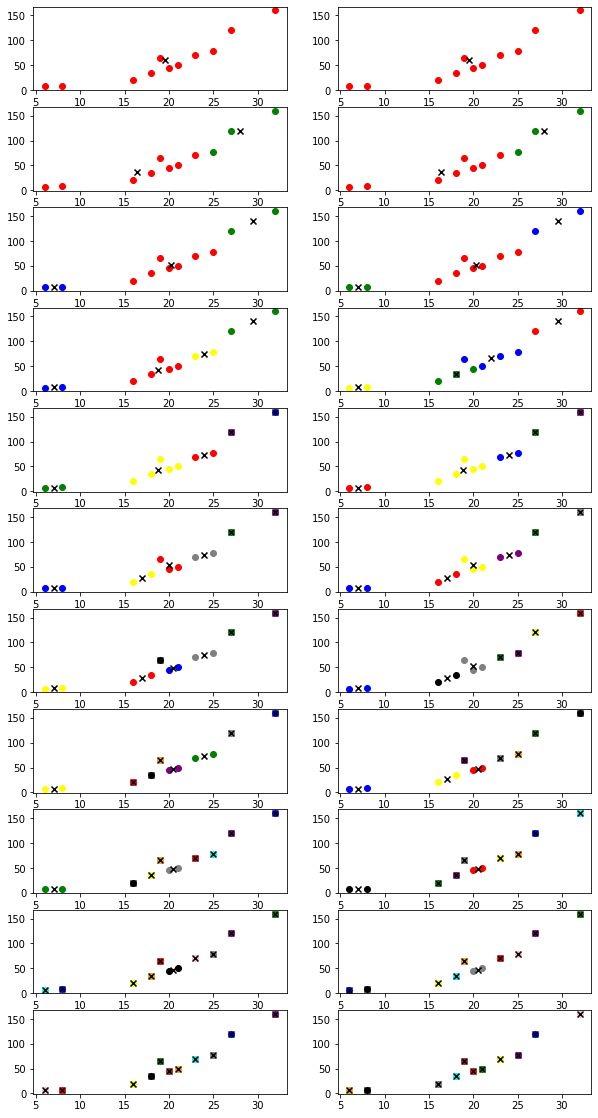

In [20]:
# sada hocemo npr da nacrtamo na nekom grafiku da se klasteri vide lepo (posto imamo 2 atributa
# crtanje je izvodljivo)

# nabrojimo neke boje jer cemo posle da probamo sa vise klastera, pa da svaki bude obojen drugom bojom
# u ekstremnom slucaju, mozemo da imamo onoliko klastera koliko imamo instanci, (u nasem skupu je to 11)
# drugi ekstremni slucaj je da imamo samo 1 klaster u kom su svi podaci
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'grey', 'black', 
          'orange', 'cyan', 'pink', 'brown']

# probamo razlicite k-ove, za nas ima smisla od 1 do 11 pa cemo za svaki da crtamo grafik
ks = range(1, X.shape[0] + 1)
# isprobacemo i razlicite metode za inicijalizaciju
init_methods = ['k-means++', 'random']

# prakticno radimo gird search rucno, ali pritom i da crtamo, zato ne korsitimo ugradjen GridSearchCV
# crtacemo sve u dve kolone, gde je red k, a kolona init metod, to radimo sa figure
# NOTE: ovo figsize se NE odnosi na broj subplotova nego na velicinu na ekranu (?)
fig = plt.figure(figsize=(10, 20))

# cuvacemo one inercije u svakoj iteraciji da bismo videli kako se smanjuju 
inertias = []

plt_index = 1
for k in ks:
    for init_method in init_methods:
        kmeans = KMeans(n_clusters=k, init=init_method)
        kmeans.fit(X)
        # listu klastera koju nam kmeans vrati mozemo da dodamo u nas dataframe
        df['label'] = kmeans.labels_
        
        # arg za subplot su koliko redova i kolona figura ima, i pozicija na koju subplot ide
        # note: ne idu indeksima [][] kao u nekoj matrici nego su numerisani redom
        fig.add_subplot(len(ks), len(init_methods), plt_index)
        # znamo da ce labeli biti nazvani 0, 1, ... k
        # hocemo sada svaki cluster da dodamo na scatter plot razlicitmo bojom
        # taj scater plot ce se nacrtati tacno na poziciji koju smo naglasili
        # sa add_subplot
        for label in range(k):
            cluster = df[df['label'] == label]
            plt.scatter(cluster['height'], cluster['weight'], color=colors[label])
            
        # mozemo na svaki crtez da dodamo i centroide
        # NOTE: primetimo da posto smo normalizovali podakte, centroidi koje dobijamo su takodje u 
        # intervalu [0, 1], ali na graficima smo za X i Y osu koristili nenormalizovane podatke direktno
        # iz dataframea
        # moramo da nekako reversujemo skaliranje, a za to imamo ugradjenu funkciju
        # TODO: proveri da li se inverzuje samo poslednja odradjena transformacija u slcucaju da smo ih 
        # uradili vise ili samo poslednja
        cs = scaler.inverse_transform(kmeans.cluster_centers_) 
        # pravimo dataframe jer nam je lakse
        centroids = pd.DataFrame(cs, columns=feature_names)
        # i dodamo na plot 
        plt.scatter(centroids['height'], centroids['weight'], marker='x', color='black')
        
        plt_index += 1
    
    # pamtimo inerciju (primetimo da ovde ispada da uzimamo inerciju samo za random metod)
    # ali svejedno nam je jer dodje na isto
    inertias.append(kmeans.inertia_)

plt.show()

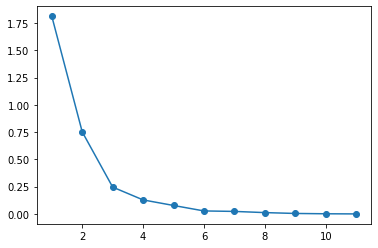

In [22]:
# plotujemo inercije da vidimo kako se smanjuju sa povecanjem klastera
plt.plot(ks, inertias, marker='o')

# primetimo da posle nekog broja klastera, smanjenje inercije nije onoliko veliko kao u proslom koraku,
# tj nije vise isplativo deliti na vise klastera. Ta granica, tj "lakat" na ovom grafiku je obicno ono
# k koje se uzima za klasterovanje (to biranje je heuristika, nije egzaktan nacin), npr ovde je 3 